In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [3]:
#ls ../../.kaggle/competitions/house-prices-advanced-regression-techniques/

In [4]:
#!cat /Users/asturges/.kaggle/competitions/house-prices-advanced-regression-techniques/data_description.txt

In [5]:
#!head /Users/asturges/.kaggle/competitions/house-prices-advanced-regression-techniques/sample_submission.csv

In [6]:
#!head /Users/asturges/.kaggle/competitions/house-prices-advanced-regression-techniques/train.csv

In [87]:
SOURCE_DIR = "/Users/asturges/.kaggle/competitions/house-prices-advanced-regression-techniques/"
raw_test = pd.read_csv(os.path.join(SOURCE_DIR, 'test.csv'))
raw_train = pd.read_csv(os.path.join(SOURCE_DIR, 'train.csv'))
raw_X_train = raw_train.drop('SalePrice', axis=1)
print("Test shape: ", raw_test.shape)
print("Train shape: ", raw_train.shape)
raw_train.head()

('Test shape: ', (1459, 80))
('Train shape: ', (1460, 81))


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


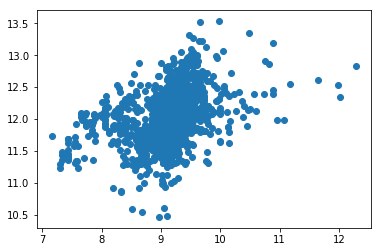

In [88]:
plt.scatter(np.log(raw_X_train.LotArea), np.log(raw_train['SalePrice']))

In [89]:
corr_matrix = raw_train.corr()
corr_matrix['SalePrice'].sort_values(ascending=False)[:5]

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64

In [90]:
columns = corr_matrix['SalePrice'].sort_values(ascending=False)[1:5].keys()
raw_train[columns].head()

,OverallQual,GrLivArea,GarageCars,GarageArea
0,7,1710,2,548
1,6,1262,2,460
2,7,1786,2,608
3,7,1717,3,642
4,8,2198,3,836


In [91]:
#try:
#    raw_train.drop(['PoolQC'], axis=1, inplace=True)
#except ValueError:
#    pass
#raw_train['LotFrontage'] = raw_train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [92]:
def remove_items_from_list(items, lst):
    return [x for x in lst if x not in items]

In [112]:
union = pd.concat([raw_X_train, raw_test])
columns_to_ignore = ['Id', 'LowQualFinSF', 'BsmtFinSF2']
numeric_columns = union.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns = remove_items_from_list(columns_to_ignore, numeric_columns)
categorical_columns = union.select_dtypes(exclude=[np.number]).columns.tolist()
categorical_columns = remove_items_from_list(columns_to_ignore, categorical_columns)
columns_have_no_nulls = pd.notnull(union[categorical_columns]).apply(np.all)
non_null_categorical_columns = list(columns_have_no_nulls[columns_have_no_nulls==True].index)
print("Numeric columns: ({})".format(len(numeric_columns)))
print(numeric_columns[:6])
print("Categorial columns: ({})".format(len(categorical_columns)))
print(categorical_columns[:6])
print("Non-null categorical columns: ({})".format(len(non_null_categorical_columns)))
print(non_null_categorical_columns)[:6]

Numeric columns: (34)
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt']
Categorial columns: (43)
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities']
Non-null categorical columns: (20)
['Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood']


In [113]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column_names=['OverallQual', 'GrLivArea', 'GarageCars']):
        self.column_names = column_names

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column_names]

In [114]:
class DataFrameCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['Alley'].fillna('no_alley', inplace=True)
        X.Fence.fillna('no_fence', inplace=True)
        X.MiscFeature.fillna('no_misc_feature', inplace=True)
        return X.drop("PoolQC", axis=1)

In [151]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(column_names=numeric_columns)),
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline(steps=[
    ('cleaner', DataFrameCleaner()),
    ('selector', DataFrameSelector(column_names=non_null_categorical_columns)),
    #('ohe', CategoricalEncoder(encoding="onehot-dense")),
])


union_pipeline = FeatureUnion(transformer_list=[('num_pipeline', num_pipeline), 
                                               ('cat_pipeline', cat_pipeline),
                                              ])
full_pipeline = Pipeline(steps=[
    ('union_pipeline', union_pipeline),
    #('pca', PCA(n_components=0.95))
])

In [120]:
selector = DataFrameSelector(column_names=numeric_columns)
t = selector.fit_transform(raw_X_train)

In [121]:
imputer = Imputer(strategy='median')
u = imputer.fit_transform(t)
v = pd.DataFrame(u, columns=numeric_columns)

In [124]:
scaler = StandardScaler()
w = pd.DataFrame(scaler.fit_transform(v), columns=numeric_columns)

In [197]:
def run_pipeline_and_do_ohe(df):
    t = full_pipeline.fit_transform(df)
    u = pd.DataFrame(t, columns=(numeric_columns+non_null_categorical_columns))
    v = pd.get_dummies(u, columns=non_null_categorical_columns)
    return v

In [198]:
print(raw_X_train.shape)
print(raw_test.shape)
union_prepped = run_pipeline_and_do_ohe(union)
X_train_prepped, X_test_prepped = union_prepped[0:raw_X_train.shape[0]], union_prepped[raw_X_train.shape[0]:]
print(X_train_prepped.shape)
print(X_test_prepped.shape)

(1460, 80)
(1459, 80)
(1460, 158)
(1459, 158)


In [171]:
X_train, X_test, y_train, y_test = train_test_split(X_train_prepped, raw_train['SalePrice'])
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1095, 158)
(1095,)
(365, 158)
(365,)


In [172]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_train_predictions = lin_reg.predict(X_train)
lin_reg_mse = mean_squared_error(y_true=y_train, y_pred=y_train_predictions)
rmse = np.sqrt(lin_reg_mse)
print("Train RMSE: {:0.0f}".format(rmse))
y_test_predictions = lin_reg.predict(X_test)
lin_reg_mse = mean_squared_error(y_true=y_test, y_pred=y_test_predictions)
rmse = np.sqrt(lin_reg_mse)
print("Test RMSE:  {:0.0f}".format(rmse))

Train RMSE: 24189
Test RMSE:  25261


In [173]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepped, raw_train['SalePrice'])
y_test_predictions = lin_reg.predict(X_test_prepped)

In [174]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepped, raw_train['SalePrice'])
y_train_predictions = lin_reg.predict(X_train_prepped)
lin_reg_mse = mean_squared_error(y_true=raw_train['SalePrice'], y_pred=y_train_predictions)
rmse = np.sqrt(lin_reg_mse)
print("Train RMSE: {:0.0f}".format(rmse))
y_test_predictions = lin_reg.predict(X_test_prepped)

Train RMSE: 23679


In [175]:
tree_reg = DecisionTreeRegressor(max_depth=3, min_samples_split=3, min_samples_leaf=5, max_features=25)
tree_reg.fit(X_train, y_train)
y_train_predictions = tree_reg.predict(X_train)
print(np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_train_predictions)))
y_test_predictions = tree_reg.predict(X_test)
print(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_test_predictions)))

# Cross Validation
scores = cross_val_score(tree_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.astype(int))
print('Mean: {:,.0f}; Std: {:,.0f}'.format(rmse_scores.mean(), rmse_scores.std()))

50698.534847193325
52352.23489913381
[55178 53404 53819 50163 43630 49307 75626 72586 53953 53982]
Mean: 56,165; Std: 9,552


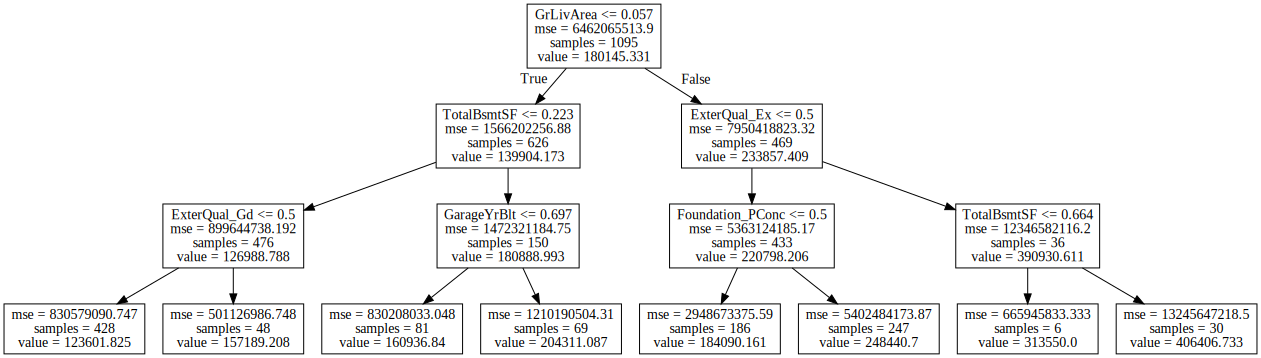

In [176]:
import graphviz
from sklearn import tree

dot_data = tree.export_graphviz(tree_reg, out_file=None, feature_names=(X_train.columns))  
graph = graphviz.Source(dot_data)  
graph

In [177]:
scores = cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.astype(int))
print('Mean: {:,.0f}; Std: {:,.0f}'.format(rmse_scores.mean(), rmse_scores.std()))

[21925 47552 26741 26644 29469 29881 85364 26665 25338 38211]
Mean: 35,780; Std: 17,964


In [178]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)
scores = cross_val_score(forest_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.astype(int))
print('Mean: {:,.0f}; Std: {:,.0f}'.format(rmse_scores.mean(), rmse_scores.std()))

[29003 32815 33163 25203 19450 28685 61236 29154 25813 33337]
Mean: 31,787; Std: 10,621


In [179]:
# grid search
forest_reg = RandomForestRegressor()
param_grid = [
    {'bootstrap': [True], 'n_estimators': [10, 30, 90],
     'max_features': [20, 40, X_train.shape[1]],
     'max_depth': [4, 6, 8], 'min_samples_leaf': [10]},
]
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_params_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
           max_features=40, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=90, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
{'max_features': 40, 'n_estimators': 90, 'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 10}


In [180]:
scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.astype(int))
print('Mean: {:,.0f}; Std: {:,.0f}'.format(rmse_scores.mean(), rmse_scores.std()))

[25769 33024 33893 27931 28460 23628 45881 42922 26245 45464]
Mean: 33,322; Std: 8,072


In [181]:
y_test_predictions = grid_search.best_estimator_.predict(X_test_prepped)

In [192]:
sorted(zip(grid_search.best_estimator_.feature_importances_, X_train.columns), reverse=True)[:10]

[(0.2543375297525036, 'OverallQual'),
 (0.15934285508603716, 'GrLivArea'),
 (0.08696737118582867, 'TotalBsmtSF'),
 (0.07614220704181339, 'GarageCars'),
 (0.06395053045962597, 'GarageArea'),
 (0.05041066160286636, '1stFlrSF'),
 (0.0501185003421195, 'YearBuilt'),
 (0.041943112935185815, 'ExterQual_TA'),
 (0.021095059991692828, 'FullBath'),
 (0.01985145749723343, 'GarageYrBlt')]

In [ ]:
kaggle_X_test_prepared = full_pipeline.transform(kaggle_test)
kaggle_y_test_predictions = grid_search.best_estimator_.predict(kaggle_X_test_prepared)

In [204]:
pd.DataFrame({'Id': raw_test.Id, 'SalePrice': y_test_predictions}).to_csv('submission.csv', index=False)

In [ ]:
cols = ['LotArea', 'LotFrontage', 'YrSold', 'YearBuilt', 'KitchenQual', 'SalePrice',
        'FullBath', 'HalfBath', 'BedroomAbvGr', 'GrLivArea']
pd.plotting.scatter_matrix(train[cols], figsize=(15, 10));

In [ ]:
# Dimensionality Reduction via PCA

pca = PCA(n_components=0.95)
pca.fit(X_train_prepped)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [46]:
print(X_train_prepped.shape)
pca.fit_transform(X_train_prepped).shape

(1460, 45)


NameError: name 'pca' is not defined

TensorFlow
---------

In [47]:
def generate_data(dataframe):
    train_x = dataframe[['GrLivArea', 'YearBuilt', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'LotArea']]
    train_x_standardized = (train_x - train_x.mean()) / train_x.std()
    neighborhood_one_hot = pd.get_dummies(dataframe[['Neighborhood', 'BldgType']])
    subclass_one_hot = pd.get_dummies(dataframe[['MSSubClass']].astype('str'))
    return pd.concat([train_x_standardized, neighborhood_one_hot, subclass_one_hot], axis=1)

Epoch: 0;	 cost: 39,157,616,640.0
Epoch: 20;	 cost: 13,342,103,552.0
Epoch: 40;	 cost: 8,432,761,344.0
Epoch: 60;	 cost: 7,395,713,536.0
Epoch: 80;	 cost: 7,096,340,992.0
Epoch: 100;	 cost: 6,952,637,440.0
Epoch: 120;	 cost: 6,853,057,536.0
Epoch: 140;	 cost: 6,773,721,600.0
Epoch: 160;	 cost: 6,707,813,888.0
Epoch: 180;	 cost: 6,652,303,872.0
Epoch: 199;	 cost: 6,607,314,432.0


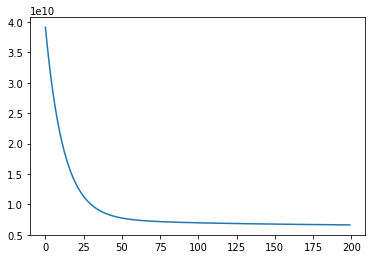

In [57]:
tf.set_random_seed(123)

training_epochs = 200
data = generate_data(raw_X_train) 
X_train, X_test, y_train, y_test = train_test_split(data, raw_train['SalePrice'])
#training_data = train[['GrLivArea', 'BedroomAbvGr', 'FullBath', 'LotArea']]
#training_data = (training_data - training_data.mean()) / training_data.std()
#training_data = neighborhood_one_hot
#training_data = train_x_standardized
#training_data = subclass_one_hot
n_rows, n_features = X_train.shape
training_costs = []
learning_rate = 0.01


g = tf.Graph()
with g.as_default():
    tf_x = tf.placeholder(dtype=tf.float32, shape=(None), name='tf_x')
    tf_y = tf.placeholder(dtype=tf.float32, shape=(None), name='tf_y')
    weight = tf.Variable(tf.random_normal(shape=(n_features, 1)), name='weight')
    bias = tf.Variable(tf.random_normal([1]), name='bias')
    y_hat = tf.add(tf.matmul(tf_x, weight), bias, name='y_hat')
    cost = tf.reduce_mean(tf.square(tf_y - y_hat), name='cost')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    training_operation = optimizer.minimize(cost, name='training_operation')

feed_dict = {tf_x: X_train, tf_y: y_train}

with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(training_epochs):
        c, _, w, b = sess.run([cost, training_operation, weight, bias], feed_dict=feed_dict)
        if np.isnan(c) or np.isinf(c):
            print("\n======aborted========")
            break
        training_costs.append(c)
        if epoch % (training_epochs / 10) == 0:
            print('Epoch: {};\t cost: {:,}'.format(epoch, c))
print('Epoch: {};\t cost: {:,}'.format(epoch, c))
plt.plot(training_costs);

In [53]:
#177739.16
print(n_features)
print(b)
print(len(w))

51
[106407.414]
51


In [58]:
np.matmul(X_train, w) + b

array([[179993.59942697],
       [194617.21408636],
       [184275.79647258],
       ...,
       [174538.52133979],
       [174217.58648244],
       [193824.52695168]])

In [60]:
mean_squared_error(y_true=y_train, y_pred=np.matmul(X_train, w) + b)

6228752335.746789

In [55]:
test_data = generate_data(raw_test)
test_data.loc[1358, 'MSSubClass_160'] = 1
test_data.drop(['MSSubClass_150'], axis=1, inplace=True)
predictions = np.matmul(test_data, w) + b
predictions[:5]
mean_squared_error()

array([[192536.31013009],
       [187807.2691366 ],
       [183942.93215234],
       [186113.68684647],
       [152286.73308601]])

In [ ]:
pd.DataFrame({'Id': test.Id, 'SalePrice': predictions.T[0]}).to_csv('submission.csv', index=False)

In [ ]:
!cat submission.csv

In [ ]:
for test_column in generate_data(test).columns:
    if test_column not in generate_data(train).columns:
        print(test_column)

In [ ]:
#y_hat = tf.add(tf.matmul(tf_x, weight), bias, name='y_hat')
np.matmul(training_data, w)
plt.hist((train['SalePrice'] - predictions.T[0])**2, bins=50, log=True);

In [61]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
m, n = housing.data.shape

(20640, 8)

In [93]:
print(housing.target.shape)
print(housing.target.reshape(-1, 1).shape)

(20640,)
(20640, 1)


In [95]:
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]
X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name='X')
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name='y')
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)
with tf.Session() as sess:
    theta_value = theta.eval()

In [87]:
m, nX_train

array([[ 8.09910853e+00,  2.83354174e+00,  1.41519207e+00, ...,
        -1.73226724e-01,  1.69324883e-01, -1.53608658e-01],
       [ 1.42387340e+00, -7.85749130e-01, -1.15277799e+00, ...,
        -9.87845241e-02,  5.32260499e-03, -1.60945901e-01],
       [-7.39957211e-02, -2.46117510e+00, -3.16638142e-01, ...,
         7.15039407e-02,  3.18798776e-02, -2.81731350e-01],
       ...,
       [-2.04031957e+00, -4.31157893e-01,  1.05803090e+00, ...,
        -2.82582986e-02,  2.60174763e-01,  4.76786712e-01],
       [-2.75052873e+00,  1.36321136e+00,  7.25558608e-01, ...,
        -2.90911991e-01,  6.61165850e-02, -1.72743010e-01],
       [-1.56236291e+00, -1.01188643e+00,  5.12983180e-01, ...,
         4.44509730e-01, -1.92230571e-01, -2.15530169e-01]])